In [1]:
import os
from sound.sound_eval import eval_sound
import numpy as np
from matplotlib import pyplot as plt
import pydub
from time_series.anomaly_detection import polyreg_outliar_mse, lof

In [2]:

folders = ["data/cust", "data/topsdata"]
data_rms = []
data_bin = []
# load "normal" data
def eval_linreg(arr, n, linreg):
    arr = np.array(arr).reshape((len(arr),))
    windows = []
    labels = []
    for i in range(len(arr)-n):
        windows.append(arr[i:i+n])
        labels.append(arr[i+n])
    return (linreg.predict(windows) - labels)**2
for dir in folders:
    for filename in os.listdir(dir):
        fil = os.path.join(dir, filename)
        print("getting", fil)
        a = pydub.AudioSegment.from_mp3(fil)
        
        y = np.array(a.get_array_of_samples())
        print(y.shape)
        data_binr, data_rmsr, _ = eval_sound(y,a)
        data_bin.append(data_binr)
        data_rms.append(data_rmsr)
        del a
        del y

linreg_rms = polyreg_outliar_mse(data_rms, 15)
linreg_bin = polyreg_outliar_mse(data_bin, 15)

getting data/cust\c1.mp3
(36240032,)


In [129]:
def SWIDE(signal, err):
    anchor = 0
    diff_mean = 0
    segms = []
    
    i = 0
    while anchor < len(signal):
        i = anchor + 1
        diffs=[]
        diff_mean = 0
        while i < len(signal) and abs(signal[i] - signal[i-1]) - diff_mean <= err :
            
            diffs.append(abs(signal[i] - signal[i-1]))
            
            i+=1
            diff_mean = np.mean(np.array(diffs))
        segms.append([anchor,np.mean(np.array(signal[anchor:i])),i])
        anchor = i
    return segms





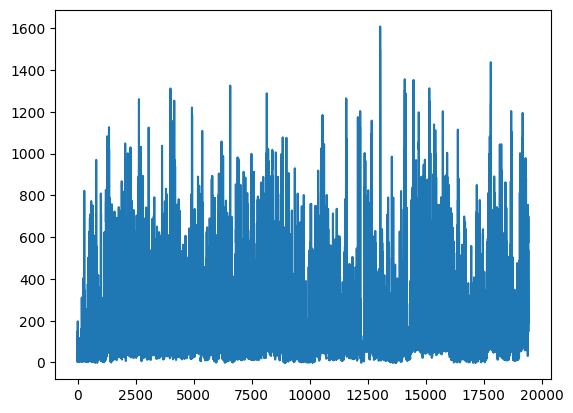

In [4]:
a = pydub.AudioSegment.from_mp3("data/custom_game.mp3")
        
y = np.array(a.get_array_of_samples())
data_binr, data_rmsr, _ = eval_sound(y,a)
plt.plot(data_binr)
plt.show()

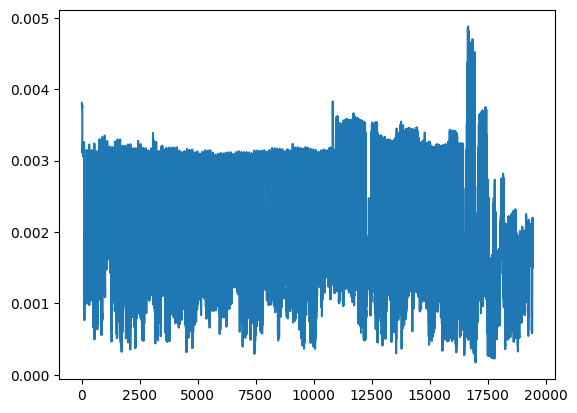

In [5]:
singl_frm = np.loadtxt("data/arr.csv", delimiter = ",")
plt.plot(singl_frm)
plt.show()

In [6]:
from pyod.models.lunar import LUNAR
from time_series.smoothening_functions import power_smooth, llr_smooth, ewma_bias_corrected, kaiser_wind,derivative
cls_l = LUNAR(n_neighbours=180)
cls_l.fit(np.array(kaiser_wind(np.array(singl_frm), 60, 2)).reshape(-1, 1))
plt.plot(cls_l.decision_scores_)
plt.show()

KeyboardInterrupt: 

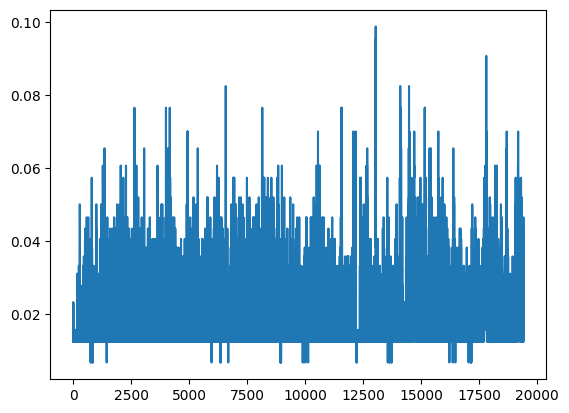

In [9]:
from pyod.models.loda import LODA
cls_ld = LODA(n_bins="auto")
cls_ld.fit(np.array(data_binr).reshape(-1, 1))
plt.plot(cls_ld.decision_scores_)
plt.show()

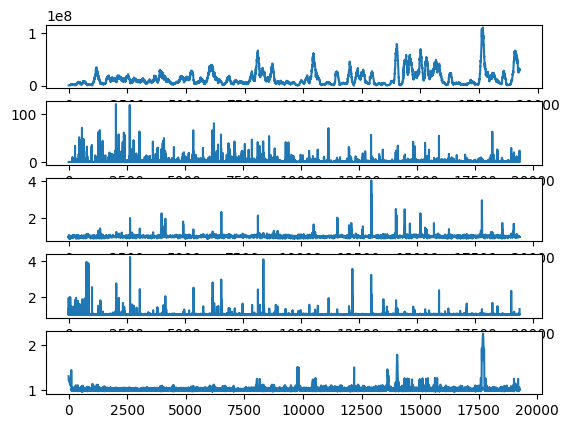

In [104]:
from time_series.smoothening_functions import power_smooth, llr_smooth, ewma_bias_corrected, kaiser_wind,derivative
fig, axs = plt.subplots(5)
    
axs[0].plot(eval_linreg(kaiser_wind(np.array(data_binr), 180, 2), 15, linreg_bin))
axs[1].plot(eval_linreg(data_rmsr, 15, linreg_rms))
axs[2].plot(lof(np.array(data_binr), 240))
axs[3].plot(lof(np.array(data_rmsr), 180))
axs[4].plot(lof(kaiser_wind(np.array(data_binr), 180, 2), 180))
plt.show()


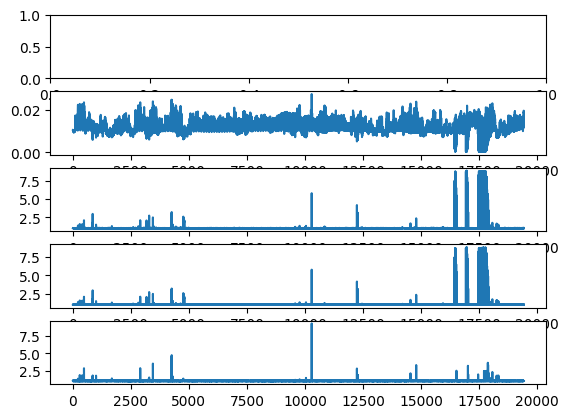

In [8]:
fig, axs = plt.subplots(5)
    
# axs[0].plot(eval_linreg(kaiser_wind(np.array(data_binr), 180, 2), 15, linreg_bin))
# axs[1].plot(eval_linreg(data_rmsr, 15, linreg_rms))
axs[1].plot(singl_frm)
axs[2].plot(lof(np.array(singl_frm), 180))
axs[3].plot(lof(np.array(singl_frm), 180))
axs[4].plot(lof(np.array(singl_frm), 45))
plt.show()

In [9]:
print(len(singl_frm[:-12]))
len(data_binr)

19422


19422

(19422, 3)
[ 3.70555556 12.06666667 16.90277778  9.76944444 11.71111111  3.775
 14.26388889 13.95       13.60555556 14.02777778 14.56666667  7.53611111]


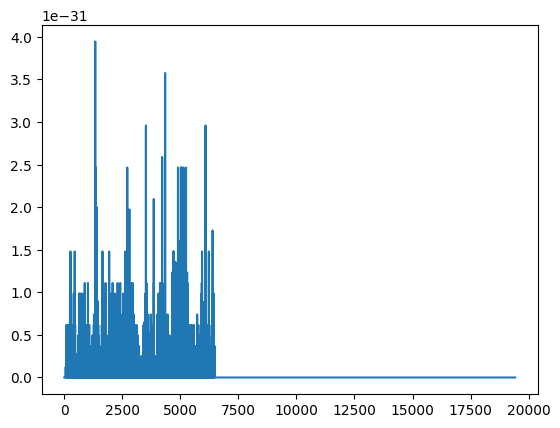

In [95]:
from time_series.anomaly_detection import pca_outliar
from sklearn.preprocessing import MinMaxScaler
from time_series.preprocessing import normalize_mean_cov
mnmx = MinMaxScaler(feature_range=(-1,1))
new_sig = np.array([data_binr, singl_frm[:-12], data_rmsr])
mnmx.fit(new_sig.reshape(-1,3))
signal = mnmx.transform(new_sig.reshape(-1,3))
# new_sig = np.array([normalize_mean_cov(data_binr) , normalize_mean_cov(data_binr), normalize_mean_cov(data_rmsr)])
# signal = new_sig.reshape(-1,3)
print(signal.shape)
res = pca_outliar(signal, 3)
print(res.argsort()[-12:][::-1]/(6*60))
plt.plot(res)

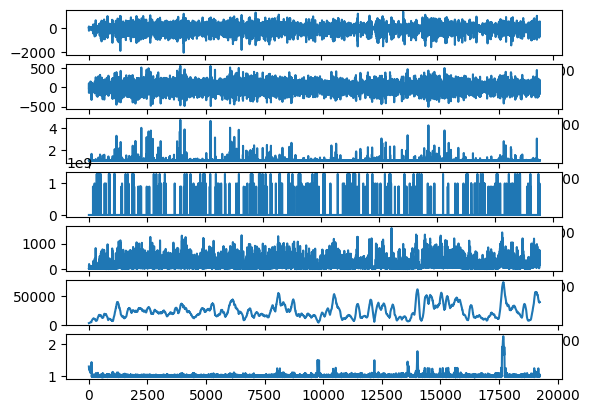

<Figure size 1800x1200 with 0 Axes>

In [28]:

fig, axs = plt.subplots(7)
plt.figure(figsize=(18,12))  
d_2 = lambda x: derivative(derivative(x))  
axs[0].plot(d_2(data_binr))
axs[1].plot(kaiser_wind(np.array(d_2(data_binr)), 180, 2))
axs[2].plot(lof(np.array(kaiser_wind(np.array(d_2(data_binr)), 180, 2)), 180))
axs[3].plot(lof(np.array(d_2(data_binr)),100))
axs[4].plot(data_binr)
axs[5].plot(kaiser_wind(np.array(data_binr), 180, 2))
axs[6].plot(lof(np.array(kaiser_wind(np.array(data_binr), 180, 2)), 180))
# axs[6].plot(ewma_bias_corrected(lof(np.array(data_rmsr), 200), 0.4))
plt.show()

In [29]:
from sklearn.ensemble import IsolationForest
def isolfor_outliar(arr):
    arr = np.array(arr).reshape(-1, 1)
    print(arr.shape)
    forr = IsolationForest(contamination=0.01).fit(arr)
    return forr
db = np.array(data_bin[0])
print(db.shape)
for i in range(6):
    if i == 0:
        continue
    db = np.concatenate((db,np.array(data_bin[i])))
forr = isolfor_outliar(db)

(4524,)
(39768, 1)


In [30]:
forr2 = isolfor_outliar(data_binr)

(19422, 1)


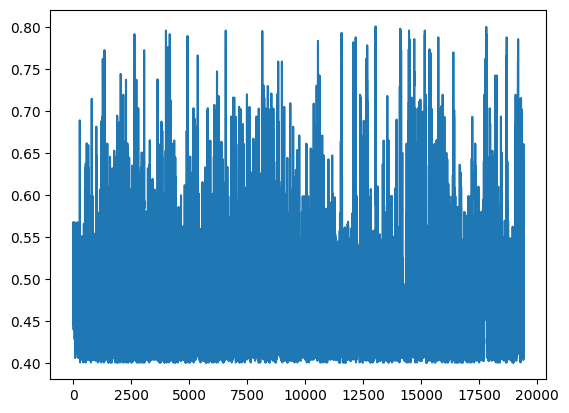

In [31]:
plt.plot(np.abs(forr2.score_samples(np.array(data_binr).reshape(-1, 1))))

In [32]:
print(np.abs(forr2.score_samples(np.array(data_binr).reshape(-1, 1))).argsort()[-12:][::-1]/(6*60))
print(np.array(power_smooth(lof(np.array(data_binr), 50), 240)).argsort()[-12:][::-1]/(6*60))
print(np.array(lof(np.array(data_binr), 50)).argsort()[-12:][::-1]/(6*60))
print(np.array(eval_linreg(data_binr, 15, linreg_bin)).argsort()[-12:][::-1]/(6*60))
print(len(data_binr)/(6*60))

[36.21111111 36.19722222 36.19444444 49.44444444 49.44722222 39.15
 39.17222222 11.11944444 18.26944444 40.2        36.21388889 42.08611111]
[42.22777778 12.90277778 27.93611111 30.57777778 49.13333333 50.60833333
 42.93333333 44.07222222 13.55277778 11.93055556  8.01666667  9.33888889]
[10.225      37.35833333 19.60277778 47.68611111 12.59444444 12.58055556
 52.18888889 23.68055556 31.24166667 20.6        20.78611111 43.59722222]
[ 8.46944444  7.30277778 36.15277778 35.15555556 42.61111111 18.22777778
  3.51944444  3.725      36.15       21.06388889 50.48333333 33.53333333]
53.95


In [33]:
from time_series.smoothening_functions import derivative
d_data_binr = derivative(derivative(data_binr))
print(np.array(lof(np.array(d_data_binr), 100)).argsort()[-12:][::-1]/(6*60))

d_data_rmsr = derivative(derivative(data_rmsr))
print(np.array(lof(np.array(d_data_rmsr), 100)).argsort()[-12:][::-1]/(6*60))

[31.60833333 37.74722222  3.08888889  9.08888889 32.31388889 21.73888889
 13.31111111 29.76944444 47.13333333  5.35555556 46.47777778 25.09444444]
[ 3.76388889 17.22777778  5.69166667 11.33888889  2.225       5.69444444
 17.225       7.33888889 17.375       3.76666667 21.94444444  5.68888889]


In [34]:
d_linreg_rms = [derivative(derivative(i)) for i in data_rms]
d_linreg_bin = [derivative(derivative(i)) for i in data_bin]

In [35]:
d_linreg_rms = polyreg_outliar_mse(d_linreg_rms, 15)
d_linreg_bin = polyreg_outliar_mse(d_linreg_bin, 15)

In [36]:
print(np.array(eval_linreg(d_data_binr, 15, d_linreg_bin)).argsort()[-12:][::-1]/(6*60))
print(np.array(eval_linreg(d_data_rmsr, 15, d_linreg_rms)).argsort()[-12:][::-1]/(6*60))


[ 7.29722222 35.15        8.46388889 42.60555556 32.10277778  3.51388889
 36.14444444 21.05833333 17.18333333 36.14722222 53.55277778  3.71944444]
[ 7.29722222  5.64722222 17.18333333 17.36666667  1.58888889 31.05
  3.72222222 50.64444444  6.59722222  3.71944444  3.51388889  6.66944444]


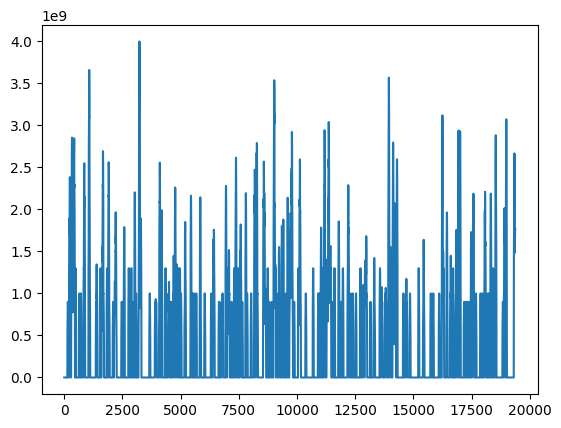

In [38]:
plt.plot(kaiser_wind(lof(np.array(d_data_binr), 100), 45,2))

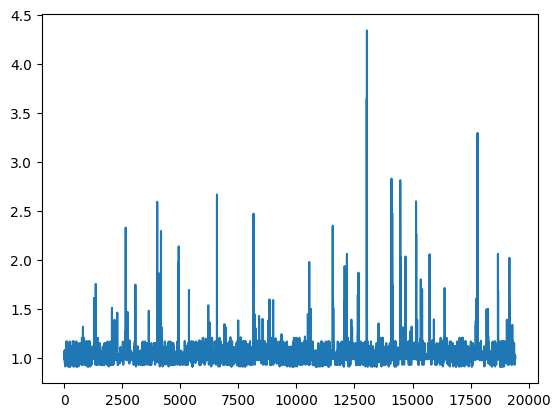

In [41]:

plt.plot(lof(np.array(data_binr), 360))

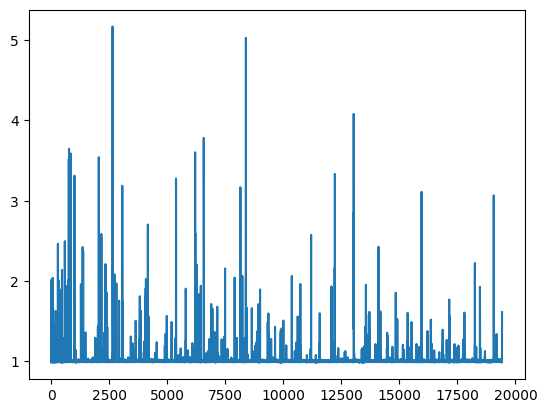

In [43]:
plt.plot(lof(np.array(data_rmsr), 360))

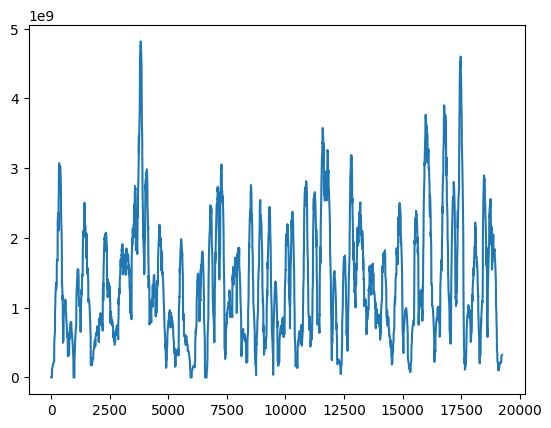

In [47]:
plt.plot(kaiser_wind(lof(np.array(data_binr), 180),180,2))

In [183]:

def SWIDE_ours(signal, thr):
    signal = np.array(signal)
    anchor = 0
    diff_mean = 0
    segms = []
    diffs = np.abs(np.array(derivative(signal)))
    print(len(diffs))
    print(thr)
    i = 0
    while i < len(signal):
        
        
        end = 90
        diff_mean = np.mean(signal[i:i+end])
        flg = False
        while i + end  < len(signal) and diff_mean >thr :
            # print(diff_mean)
            flg = True
            
            end+=1
            diff_mean = np.mean(signal[i:i+end])
        if flg:
            segms.append([i,np.mean(np.array(signal[i:i+end])), np.max(np.array(signal[i:i+end])),i+end])
            i = i+end
        i+=1
    return segms

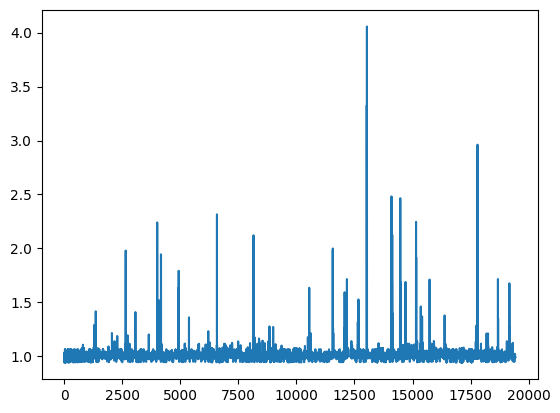

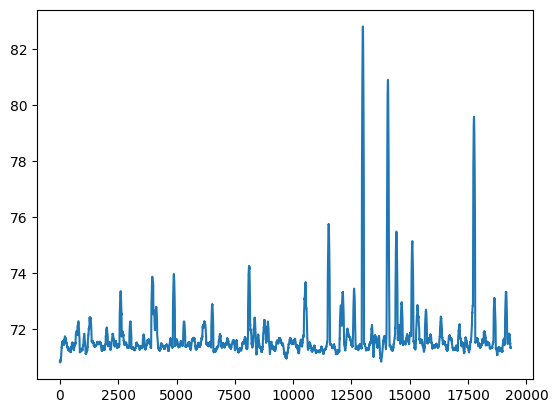

19332
71.74873012485406
10
1.8083333333333333 2.4944444444444445 71.74744114580352 72.27802821333293 651 898
3.2694444444444444 4.241666666666666 71.74860926622134 72.41033521977694 1177 1527
5.363888888888889 5.747222222222222 71.7473026869059 72.05770431372595 1931 2069
6.919444444444444 8.791666666666666 71.74805376169547 73.34839780473854 2491 3165
10.683333333333334 15.897222222222222 71.74872720779358 73.94898471030967 3846 5723
16.794444444444444 17.869444444444444 71.74847952933017 72.27454907350105 6046 6433
17.872222222222224 18.56388888888889 71.7469547769323 72.88119639062425 6434 6683
22.205555555555556 25.70277777777778 71.74854860879543 74.2415208817025 7994 9253
28.841666666666665 30.56111111111111 71.7478164159095 73.67217249774065 10383 11002
31.67222222222222 53.702777777777776 71.98560472892655 82.79350276439575 11402 19333


In [185]:
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
interm = np.array(data_binr)
interm  = lof(interm, 220)
plt.plot(interm)
plt.show()
interm  =kaiser_wind(interm, 90, 2)
plt.plot(interm)
plt.show()
segms = SWIDE_ours(interm, np.mean(interm[interm>0])*1)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    print(s[0]/360, s[-1]/360, s[1], s[2], s[0],s[-1])

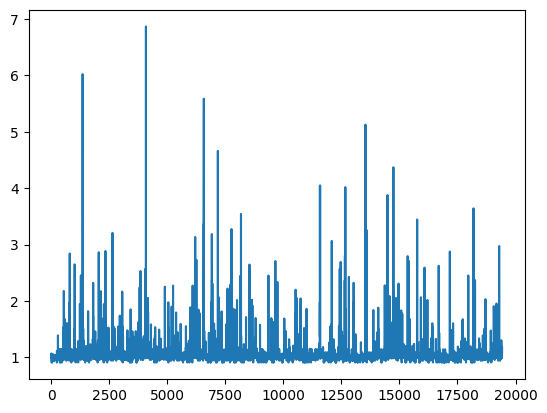

19420it [00:17, 1132.30it/s]


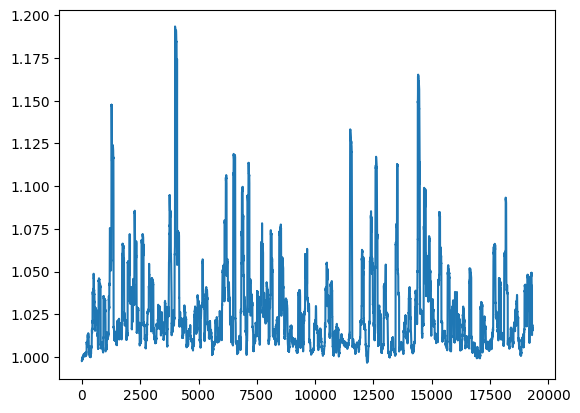

19330
1.078530704013294
11
3.308333333333333 3.908333333333333 1.078463292620911 1.147707757854013 1191 1407
10.91388888888889 11.855555555555556 1.0784899496235338 1.1935490855127613 3929 4268
16.947222222222223 17.266666666666666 1.0783569200966878 1.106485296891723 6101 6216
17.93611111111111 18.322222222222223 1.078518181053554 1.118896326314676 6457 6596
18.95 19.233333333333334 1.0783236759690535 1.0996221974852332 6822 6924
19.644444444444446 19.983333333333334 1.078157009411956 1.1137127024920874 7072 7194
31.805555555555557 32.236111111111114 1.0781547820260633 1.1332539426406845 11450 11605
34.84444444444444 35.22222222222222 1.078206627779972 1.1172224299388993 12544 12680
37.34166666666667 37.63055555555555 1.0784015293777212 1.112848035992348 13443 13547
39.827777777777776 40.475 1.0783626134460274 1.1653264727397254 14338 14571
40.66111111111111 40.97222222222222 1.0784673136052814 1.0990241710180233 14638 14750


In [186]:
from time_series.smoothening_functions import llr_smooth
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
interm = np.array(d_2(data_binr))
interm  = lof(interm, 360)
plt.plot(interm)
plt.show()
interm  =np.array(llr_smooth(interm, 90))
plt.plot(interm)
plt.show()
segms = SWIDE_ours(interm, np.mean(interm[interm>0])*1.05)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    print(s[0]/360, s[-1]/360, s[1], s[2], s[0],s[-1])

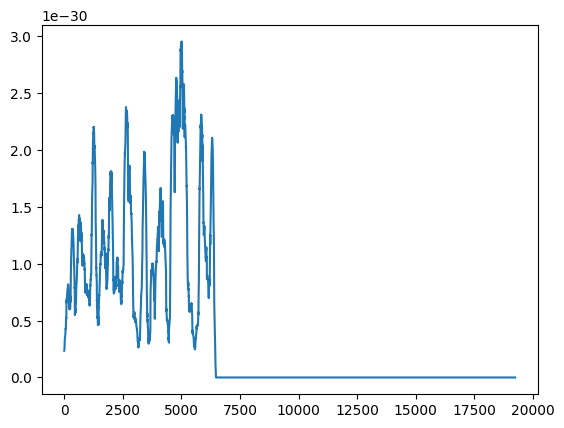

19242
1.5343788970595677e-30
7
3.1777777777777776 3.938888888888889 1.5313360669015487e-30 2.2025372620513448e-30 1144 1418
5.252777777777778 5.813888888888889 1.533781034649329e-30 1.8148819255152687e-30 1891 2093
6.980555555555555 8.358333333333333 1.5323877467603183e-30 2.3773783755013578e-30 2513 3009
9.227777777777778 9.813888888888888 1.5331683480957613e-30 1.985481087738056e-30 3322 3533
11.230555555555556 11.488888888888889 1.5335745137338903e-30 1.6668632506234043e-30 4043 4136
12.511111111111111 17.055555555555557 1.534250103318498e-30 2.9540594440595922e-30 4504 6140
17.25 17.825 1.5293540201961895e-30 2.1083735272992275e-30 6210 6417


In [187]:
intrm = kaiser_wind(res, 180, 2)
plt.plot(intrm)
plt.show()

segms = SWIDE_ours(intrm, np.median(intrm[intrm>0])*1.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    print(s[0]/360, s[-1]/360, s[1], s[2], s[0],s[-1])

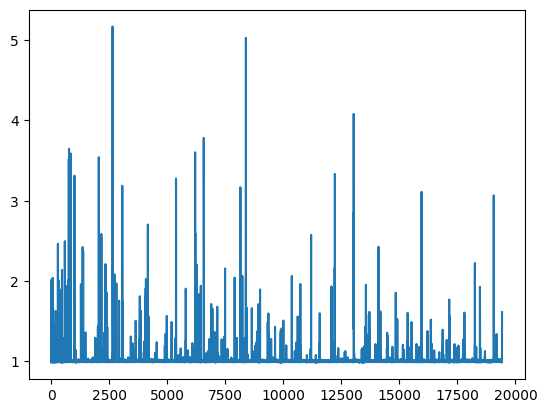

19421
1.0704320167929167
11
0.0 1.961111111111111 1.0704301238939726 0 706 2.4958498963267637
1.9638888888888888 4.15 1.070407313567683 707 1494 3.6467066437489972
5.4527777777777775 5.7972222222222225 1.0701500373684985 1963 2087 3.542662038244511
7.102777777777778 7.563888888888889 1.0701272252517438 2557 2723 5.170928283374102
14.7 14.994444444444444 1.0701634515630003 5292 5398 3.2768721456802794
17.116666666666667 17.644444444444446 1.0701120257877568 6162 6352 3.6030833205676065
18.030555555555555 18.316666666666666 1.070209107601556 6491 6594 3.7829095349810604
22.413888888888888 22.666666666666668 1.070423554382454 8069 8160 3.1669588710171803
23.052777777777777 23.52777777777778 1.070065177039982 8299 8470 5.029382439625817
35.952777777777776 36.55833333333333 1.0702553504556143 12943 13161 4.08112110509155
38.955555555555556 39.486111111111114 1.0704203378128008 14024 14215 2.426148604989392


In [184]:
interm = np.array(data_rmsr)
interm  = lof(interm, 360)
plt.plot(interm)
plt.show()
# interm  =kaiser_wind(interm, 10, 5)
# plt.plot(interm)
# plt.show()
segms = SWIDE_ours(interm, np.mean(interm)*1.05)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    print(s[0]/360, s[-1]/360, s[1], s[0],s[-1], s[2])

53.93333333333333


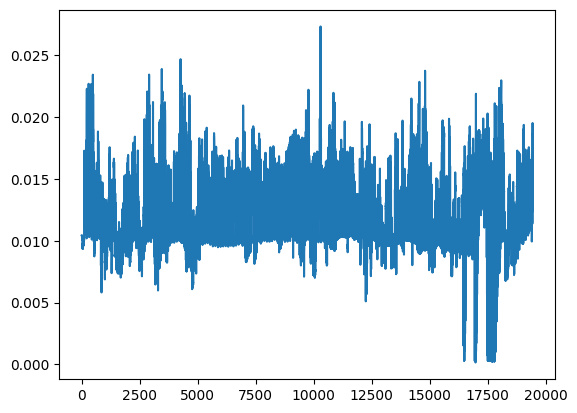

19433
0.016324431718492915
14
0.4777777777777778 1.5777777777777777 0.016320169950374448 0.023436011746525764 172 568
7.638888888888889 7.916666666666667 0.016310810847207903 0.02207588031888008 2750 2850
9.472222222222221 9.744444444444444 0.016319215829883302 0.02389739267528057 3410 3508
11.613888888888889 12.466666666666667 0.016306665895888976 0.024690836668014526 4181 4488
20.308333333333334 20.566666666666666 0.01631587302131999 0.01926313526928425 7311 7404
22.730555555555554 22.991666666666667 0.0163161630167606 0.017651397734880447 8183 8277
26.872222222222224 27.28611111111111 0.016317564150281 0.022219005972146988 9674 9823
29.433333333333334 29.694444444444443 0.01631734113981749 0.01937299221754074 10596 10690
29.84722222222222 30.511111111111113 0.016324394347465687 0.021971922367811203 10745 10984
39.99166666666667 40.266666666666666 0.01628437822665831 0.018625088036060333 14397 14496
40.669444444444444 41.53611111111111 0.016318949411073938 0.023755906149744987 14641 

In [232]:


linreg_new = polyreg_outliar_mse([singl_frm], 18)

intrm = eval_linreg(singl_frm, 18, linreg_new)
print(len(intrm)/360)
intrm  = singl_frm
plt.plot(intrm)
plt.show()

segms = SWIDE_ours(intrm, np.mean(intrm[intrm>0])*1.25)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    print(s[0]/360, s[-1]/360, s[1], s[2], s[0],s[-1])